# Final Project for New Methods in Earth Observation

### Adeline Akansobe, Kwabena Antwi, André Luiz de Oliveira Domingues

#### Fall 2023 - Professor Lyndon Estes

In this project we run the Presto demo on TreeSat data and modify it to create predictions for all pixels in the test data. We then visualize the models predictions. The original demo can be found [here](https://github.com/nasaharvest/presto/blob/main/downstream_task_demo.ipynb). This demo was run on our local computers using docker.

# Using Presto for Predicting 3 tree species

The purpose of this notebook is to demonstrate how Presto (and utility functions in the Presto package) can be used for downstream tasks.

We adapted the same process to predict three species instead of the two species predictions. We considered Pinus-nigra, Tilia_spec and Fraxinus_excelsiors

To do this, we used the [TreeSat](https://essd.copernicus.org/articles/15/681/2023/) benchmark dataset.

# Installations and imports

In [ ]:
%%capture
!! pip install xarray
!! pip install pyproj
!! pip install ee
!! pip install earthengine-api
!! pip install geopandas
!! pip install webdataset
!! pip install hurry
!! pip install hurry.filesize
!! pip install openmapflow
!! pip install einops

!! pip install rioxarray
!! pip install dask
!! pip install pystac_client
!! pip install typing_extensions==4.7.1
!! pip install planetary_computer
!! pip install leafmap
!! pip install geogif
!! pip install stackstac

!! pip install rio-cogeo

In [ ]:
# imports added by us
from pathlib import Path
from datetime import datetime
import numpy as np
import re
import os
from pathlib import Path
import rasterio
from subprocess import run
import matplotlib.pyplot as plt
import shutil
import pyproj

#---------------------------

from io import StringIO
import rioxarray
import xarray
from pyproj import Transformer
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, TensorDataset

# import the model
import presto

# this is to silence the xarray deprecation warning.
# Our version of xarray is pinned, but we'll need to fix this
# when we upgrade
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Access data

This requires the S2 data to be downloaded from [Zenodo](https://zenodo.org/record/6780578) and unzipped in the [treesat folder](data/treesat).

In [ ]:
# Define paths

# Treesat folder path
treesat_folder = presto.utils.data_dir / "treesat"
assert treesat_folder.exists()

# this folder should exist once the s2 file from zenodo has been unzipped
s2_data_60m = treesat_folder / "s2/60m"
assert s2_data_60m.exists()


For simplicity, we will only consider classification between 3 tree species: Pinus-nigra, Tilia_spec and Fraxinus_excelsiors.

The TreeSatAI S2 data contains the following bands: ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B11", "B12", "B1", "B9"]

In [ ]:
ALL_SPECIES = set()

# Reading filenames from the directory
for file in treesat_folder.glob("*.tif"):
    parts = file.stem.split('_')  # .stem gives the filename without the suffix
    tree_name = '_'.join(parts[:2])  # Join the first two parts
    ALL_SPECIES.add(tree_name)

# Reading additional filenames from train_filenames.lst
with (treesat_folder / "train_filenames.lst").open("r") as f:
    for line in f:
        parts = line.strip().split('_')
        tree_name = '_'.join(parts[:2])
        ALL_SPECIES.add(tree_name)

# Print the unique tree names
for name in ALL_SPECIES:
    print(name)

#print(len(ALL_SPECIES))

Pinus_strobus
Fraxinus_excelsior
Quercus_petraea
Cleared_0
Quercus_rubra
Populus_spec.
Larix_decidua
Prunus_spec.
Acer_pseudoplatanus
Pseudotsuga_menziesii
Alnus_spec.
Pinus_nigra
Larix_kaempferi
Picea_abies
Pinus_sylvestris
Fagus_sylvatica
Abies_alba
Quercus_robur
Tilia_spec.
Betula_spec.
20


In [ ]:
TREESATAI_S2_BANDS = ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B11",
                      "B12", "B1", "B9"]

# Tree species names
#SPECIES = ["Abies_alba", "Acer_pseudoplatanus", "Picea_abies"]
SPECIES = ["Pinus_nigra", "Tilia_spec", "Fraxinus_excelsior"] #2946
#SPECIES = ["Quercus_robur", "Larix_decidua", "Fagus_sylvatica"] #10148
#SPECIES = ["Pinus_nigra", "Larix_decidua", "Fraxinus_excelsior"]

### 1. Processing the data
#### The TreeSatAI data is stored in `.tif` files that are 6 by 6 pixel chips at 10 meter resolution. We modified this section to extract all 36 pixels from the iput data chips. The original demo only extracted 9 pixels to construct the input data.

In [ ]:
# ORIGINAL DEMO:
# takes a (6, 6) treesat tif file, and returns a
# (9,1,18) cropharvest eo-style file (with all bands "masked"
# except for S1 and S2)
#INDICES_IN_TIF_FILE = list(range(0, 6, 2))
# skip every 1 indice and take pixels 0, 2, 4

#-------------------------------------------------------------------------------
# Modified to take all pixels in input chips.
INDICES_IN_TIF_FILE = list(range(0, 6, 1))

with (treesat_folder / "train_filenames.lst").open("r") as f:
    train_files = [line for line in f if (line.startswith(SPECIES[0]) or
                                          line.startswith(SPECIES[1]) or
                                          line.startswith(SPECIES[2]) )]
                                          #or line.startswith(SPECIES[3]))]

with (treesat_folder / "test_filenames.lst").open("r") as f:
    test_files = [line for line in f if (line.startswith(SPECIES[0]) or
                                         line.startswith(SPECIES[1]) or
                                         line.startswith(SPECIES[2]) )]
                                          #or line.startswith(SPECIES[3]))]

print(f"{len(train_files)} train files and {len(test_files)} test files")

2946 train files and 321 test files


### Here the model defines the function that will process the train and test data.
#### We added modifications (.to(device)) to try and run the tensors on GPU.

We use `presto.construct_single_presto_input` to transform the TreeSat S2 data into the tensors expected by Presto.

In [ ]:
# Adapted to run training with GPU instead of CPU

def process_images(filenames, device='cpu'):
    arrays, masks, latlons, image_names, labels, \
    dynamic_worlds = [], [], [], [], [], []

    for filename in tqdm(filenames):
        # tif_file = xarray.open_rasterio(s2_data_60m / filename.strip())
        tif_file = rioxarray.open_rasterio(s2_data_60m / filename.strip())
        # crs = tif_file.crs.split("=")[-1]
        crs = tif_file.rio.crs #.split("=")[-1] Mike removed this
        transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

        #Nested y loop in x loop means that the model will process all the rows
        #in a column before moving on to the next column
        for x_idx in INDICES_IN_TIF_FILE:
            for y_idx in INDICES_IN_TIF_FILE:

                # firstly, get the latitudes and longitudes
                x, y = tif_file.x[x_idx], tif_file.y[y_idx]

                lon, lat = transformer.transform(x, y)

                latlons.append(torch.tensor([lat, lon]).to(device))

                # then, get the eo_data, mask and dynamic world
                s2_data_for_pixel = torch.from_numpy(
                    tif_file.values[:, x_idx, y_idx].astype(int)).float()
                #print('s2_data_for_pixel: ', s2_data_for_pixel) ###
                s2_data_with_time_dimension = s2_data_for_pixel.unsqueeze(0)
                #print('s2_data_with_time_dimension: ',
                #s2_data_with_time_dimension) ###
                x, mask, dynamic_world = presto.construct_single_presto_input(
                    s2=s2_data_with_time_dimension, s2_bands=TREESATAI_S2_BANDS
                )

                arrays.append(x.to(device))
                masks.append(mask.to(device))
                dynamic_worlds.append(dynamic_world.to(device))

                # Adapt for more tree species
                # Loop through each file in the list 'filenames'
                if filename.startswith("Pinus"):
                    labels.append(0)
                elif filename.startswith("Tilia"):
                    labels.append(1)
                else:
                    labels.append(2)

                image_names.append(filename)

    return (torch.stack(arrays, axis=0),
            torch.stack(masks, axis=0),
            torch.stack(dynamic_worlds, axis=0),
            torch.stack(latlons, axis=0),
            torch.tensor(labels).to(device),
            image_names,
        )

#### Process the training and test data.


In [ ]:
# Set function to run training on GPU (Cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data = process_images(train_files, device=device)

100%|███████████████████████████████████████| 2946/2946 [03:20<00:00, 14.71it/s]


In [ ]:
test_data = process_images(test_files, device=device)

100%|█████████████████████████████████████████| 321/321 [00:21<00:00, 14.77it/s]


### 2. Using Presto as a feature extractor for a random forest

One way to use Presto is as a feature extractor for a simple model (e.g. a Random Forest). We do this below.

We load the pretrained Presto model using `Presto.load_pretrained()`.

In [ ]:
batch_size = 64

pretrained_model = presto.Presto.load_pretrained()
pretrained_model.eval()

Presto(
  (encoder): Encoder(
    (eo_patch_embed): ModuleDict(
      (S1): Linear(in_features=2, out_features=128, bias=True)
      (S2_RGB): Linear(in_features=3, out_features=128, bias=True)
      (S2_Red_Edge): Linear(in_features=3, out_features=128, bias=True)
      (S2_NIR_10m): Linear(in_features=1, out_features=128, bias=True)
      (S2_NIR_20m): Linear(in_features=1, out_features=128, bias=True)
      (S2_SWIR): Linear(in_features=2, out_features=128, bias=True)
      (ERA5): Linear(in_features=2, out_features=128, bias=True)
      (SRTM): Linear(in_features=2, out_features=128, bias=True)
      (NDVI): Linear(in_features=1, out_features=128, bias=True)
    )
    (dw_embed): Embedding(10, 128)
    (latlon_embed): Linear(in_features=3, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)

We will start by constructing features for the training data, and using this to train a Random Forest.

In [ ]:
# the treesat AI data was collected during the summer,
# so we estimate the month to be 6 (July)
month = torch.tensor([6] * train_data[0].shape[0]).long()

dl = DataLoader(
    TensorDataset(
        train_data[0].float(),  # x
        train_data[1].bool(),  # mask
        train_data[2].long(),  # dynamic world
        train_data[3].float(),  # latlons
        month
    ),
    batch_size=batch_size,
    shuffle= False,
)

In [ ]:
pretrained_model = pretrained_model.to(device)  # Move model to GPU

features_list = []
for (x, mask, dw, latlons, month) in tqdm(dl):
    x, mask, dw, latlons, month = (x.to(device), mask.to(device),
                                   dw.to(device),latlons.to(device),
                                   month.to(device))  # Move all tensors to GPU

    with torch.no_grad():
        encodings = pretrained_model.encoder(x, dynamic_world=dw, mask=mask,
                                             latlons=latlons, month=month)
        encodings = encodings.cpu().numpy()  # Move encodings back to CPU
        features_list.append(encodings)

features_np = np.concatenate(features_list)

100%|███████████████████████████████████████| 1658/1658 [00:16<00:00, 99.44it/s]


In [ ]:
len(features_np)

106056

In [ ]:
len(train_data[4].cpu().numpy())

106056

# Run the model
## We use `features_np` to train a Random Forest classifier:

In [ ]:
# Run the model on a random forest classifier
model = RandomForestClassifier(class_weight="balanced", random_state=42)

if device == 'cpu':
    # ORIGINAL CODE THAT JUST USED CPU
    model.fit(features_np, train_data[4].numpy())
else:
    # ADAPTED WITH GPU. MUST CONVERT BACK TO CPU TO CONVERT TENSOR TO NUMPY
    model.fit(features_np, train_data[4].cpu().numpy())


We can then use this trained random forest to make some predictions on the test data.

In [ ]:
# the treesat AI data was collected during the summer,
# so we estimate the month to be 6 (July)
month = torch.tensor([6] * test_data[0].shape[0]).long()

dl = DataLoader(
    TensorDataset(
        test_data[0].float(),  # x
        test_data[1].bool(),  # mask
        test_data[2].long(),  # dynamic world
        test_data[3].float(),  # latlons
        month
    ),
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
# Move model to GPU
pretrained_model = pretrained_model.to(device)

features_list = []
for (x, mask, dw, latlons, month) in tqdm(dl):

    x, mask, dw, latlons, month = (x.to(device), mask.to(device),
                                   dw.to(device),latlons.to(device),
                                   month.to(device))  # Move all tensors to GPU

    with torch.no_grad():
        encodings = pretrained_model.encoder(x, dynamic_world=dw, mask=mask,
                                             latlons=latlons, month=month)
        encodings = encodings.cpu().numpy()  # Move encodings back to CPU
        features_list.append(encodings)

features_np = np.concatenate(features_list)

100%|████████████████████████████████████████| 181/181 [00:01<00:00, 102.86it/s]


# The prediction output
## Apply the model to predict pixels on the test files.



In [ ]:
latlons_list = []
test_preds = []

for (x, mask, dw, latlons, month) in tqdm(dl):
    with torch.no_grad():
        pretrained_model.eval()
        encodings = pretrained_model.encoder(
            x, dynamic_world=dw, mask=mask, latlons=latlons, month=month
        ).cpu().numpy()

        # Get predictions and append to test_preds list
        test_preds.append(model.predict_proba(encodings))

        # Append latlons for each batch to latlons_list
        latlons_list.append(latlons.cpu().numpy())

100%|█████████████████████████████████████████| 181/181 [00:02<00:00, 64.59it/s]


### We take the mode of the 36 pixels we processed as the prediction for a single image

In [ ]:
# Process predictions
pix_per_image = len(INDICES_IN_TIF_FILE) ** 2

test_preds_np = np.concatenate(test_preds, axis=0)
test_preds_np = np.reshape(
    test_preds_np,
    (int(len(test_preds_np) / pix_per_image),
     pix_per_image, test_preds_np.shape[-1]),
)
# then, take the mode of the model predictions
test_preds_np_argmax = stats.mode(
    np.argmax(test_preds_np, axis=-1), axis=1, keepdims=False
)[0]

# Process latlons
latlons_np = np.concatenate(latlons_list, axis=0)
latlons_np = np.reshape(latlons_np, (int(len(latlons_np) / pix_per_image),
                                     pix_per_image, -1))


## Display the results of the prediction on two images.

In [ ]:
def print_image_predictions(img_index_first, img_index_last=None,
                            SPECIES=SPECIES, test_preds_np=test_preds_np,
                            test_preds_np_argmax=test_preds_np_argmax,
                            latlons_np=latlons_np):
    if img_index_last is None:
        img_index_last = img_index_first

    img_index_range = range(img_index_first, img_index_last + 1)

    for img_index in img_index_range:
        if img_index >= len(test_preds_np):
            print(f"Image index {img_index} is out of range.")
            continue

        mode_prediction = test_preds_np_argmax[img_index]
        mode_species = SPECIES[mode_prediction]
        print(f"Mode Prediction for Image {img_index}:" \
                  f"{mode_prediction} ({mode_species})\n")

        header = f"{'Pixel Index':<12} {'Prediction':<30}" \
                    f"{'Species Proportions':<30} {'Lat, Lon':<30}"
        print(header)
        print("-" * len(header))

        for pixel_index in range(pix_per_image):
            pixel_pred_index = np.argmax(test_preds_np[img_index, pixel_index])
            pixel_species = SPECIES[pixel_pred_index]
            pixel_latlon = latlons_np[img_index, pixel_index]
            class_proportions = test_preds_np[img_index, pixel_index]
            row = f"{pixel_index:<12} {pixel_pred_index} ({pixel_species:<})"\
            f"{'' :>15} {str(class_proportions):<30} {str(pixel_latlon):<30}"
            print(row)

        print("\n")

# Example Usage
print_image_predictions(24, 25)

Mode Prediction for Image 24:2 (Fraxinus_excelsior)

Pixel Index  Prediction                    Species Proportions            Lat, Lon                      
--------------------------------------------------------------------------------------------------------
0            2 (Fraxinus_excelsior)                [0.04 0.01 0.95]               [51.605843 10.569197]         
1            2 (Fraxinus_excelsior)                [0.1  0.05 0.85]               [51.60575  10.569194]         
2            2 (Fraxinus_excelsior)                [0.05 0.05 0.9 ]               [51.60566 10.56919]           
3            2 (Fraxinus_excelsior)                [0.07 0.02 0.91]               [51.60557  10.569187]         
4            2 (Fraxinus_excelsior)                [0.01 0.04 0.95]               [51.60548  10.569184]         
5            2 (Fraxinus_excelsior)                [0.03 0.   0.97]               [51.605392 10.569181]         
6            2 (Fraxinus_excelsior)                [0.15 0.

And finally, we can compute the F1 score of the test predictions.

In [ ]:
if device == 'cpu':
    # ORIGINAL THAT JUST USED CPU
    target = np.reshape(test_data[4].cpu(),
                            (int(len(test_data[4]) / pix_per_image),
                             pix_per_image))[:, 0]
else:
    # CODE FOR GPU USE
    target = np.reshape(test_data[4].cpu(),
                    (int(len(test_data[4]) / pix_per_image),
                                         pix_per_image))[:, 0]

#Print F1 score
f1_score(target, test_preds_np_argmax, average="weighted")

0.9147113705531251

# Export predictions

#### Remove \n from test_files name so that code will work with Path function

In [ ]:
# # Remove \n from file names in .lst doc. (possible bug)
test_files = [re.sub("\n", "", f) for f in test_files]
print(test_files[0])

Fraxinus_excelsior_10_173918_BI_NLF.tif


## Save predictions as tifs

In [ ]:
# Redefine the paths for input60m and predictions if needed
# s2_data_60m = treesat_folder / "s2/60m"

#Path for test files
test_file_paths = [Path(f"{s2_data_60m}/{img}") for img in test_files]

# Other initializations
prediction_number = 1
current_date = datetime.now().strftime("%Y-%m-%d")
output_folder_name = f"{prediction_number}_{len(SPECIES)}species_{current_date}"
#Path to save predictions
predictions_path = "/home/workdir/predictions3"
output_dir = Path(f"{predictions_path}/{output_folder_name}")
output_dir.mkdir(parents=True, exist_ok=True)

#Function to add prediction band to test files
def add_prediction_band(raster_path, predictions, output_path):
    with rasterio.open(raster_path) as src:
        meta = src.meta
        data = src.read()
        new_data = np.append(data, predictions[np.newaxis, :, :], axis=0)
        meta.update(count=new_data.shape[0])
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(new_data)

# Process each file and save the output
for idx, raster_path in enumerate(test_file_paths):
    absolute_path = (Path(s2_data_60m) / raster_path.name)
    try:
        with rasterio.open(absolute_path) as src:
            # Apply np.argmax along axis 1 to get the index of max value
            # (class) for each pixel
            preds_for_raster = np.argmax(test_preds_np[idx], axis=1)
            preds_for_raster = preds_for_raster.reshape(
                (src.height, src.width))  # Reshape to image dimensions

            output_path = output_dir / f'{raster_path.stem}_predicted_{idx}.tif'
            add_prediction_band(absolute_path, preds_for_raster, output_path)
    except Exception as e:
        print(f"Error processing file {raster_path}: {e}")


## Transform the prediction tifs into COGs

Since we are working with small output files, this step could be skipped.


In [ ]:
#Function TO COGIFY
def cogify(input_tif):
    output_cog = re.sub('.tif', '_cog.tif', input_tif)
    cmd = ['rio', 'cogeo', 'create', input_tif, output_cog]
    p = run(cmd, capture_output=True)
    if p.returncode != 0:
        print(f"Error in COG creation: {p.stderr.decode()}")
        return
    #print(f"COG created: {output_cog}")

    # Validate the COG
    cmd = ['rio', 'cogeo', 'validate', output_cog]
    p = run(cmd, capture_output=True)
    #print(f'Validation result: {p.stdout.decode()}')

    if os.path.exists(output_cog):
        os.remove(input_tif)

# Specify the output directory containing the TIFF files, overwriting
output_dir = Path(f"{predictions_path}/{output_folder_name}")

# Iterate over each TIFF file in the output directory
# tiffs are replaced with COGS(geotiffs)
for tif_file in output_dir.glob("*.tif"):
    cogify(str(tif_file))

### Visualize and test if saved files have correct prediction values

In [ ]:
output_dir

PosixPath('/home/workdir/predictions3/1_3species_2023-12-19')

In [ ]:
#Output path
output_dir = Path(f"{predictions_path}/{output_folder_name}")

# Get the name of the first file in test_file_paths for reference
original_file = test_file_paths[304].stem


# Construct the path to the first saved raster file
saved_file = f'{output_dir}/{original_file}_predicted_304_cog.tif'

# Open the raster file and read the last band (prediction band)
with rasterio.open(saved_file) as src:
    # Assuming the prediction band is the last band
    prediction_band = src.read(src.count)

    # Print the pixel values of the prediction band
    print("Prediction Band Pixel Values:")
    print(prediction_band)

    # Since we have opened the src here, we can now get its dimensions
    src_height, src_width = src.height, src.width

# Optionally, you can also compare it to test_preds_np[0]
# Reshape it to match the dimensions of the source image
expected_predictions = (np.argmax(test_preds_np[304], axis=1)
                        .reshape((src_height, src_width)))
print("\nExpected Predictions from test_preds_np[0]:")
print(expected_predictions)


Prediction Band Pixel Values:
[[2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]

Expected Predictions from test_preds_np[0]:
[[2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]


# Extract and Visualize Distribution of Tree species
### Identify the mode species of each image and sparate them into folders by majority species.

In [ ]:
# Paths and variable definitions
prediction_tiffs_folder_path = str(predictions_path / output_dir)
mode_species0_dir = os.path.join(prediction_tiffs_folder_path, "mode_species0")
mode_species1_dir = os.path.join(prediction_tiffs_folder_path, "mode_species1")
mode_species2_dir = os.path.join(prediction_tiffs_folder_path, "mode_species2")

# Create directories if they don't exist
os.makedirs(mode_species0_dir, exist_ok=True)
os.makedirs(mode_species1_dir, exist_ok=True)
os.makedirs(mode_species2_dir, exist_ok=True)

# Number of classes based on the SPECIES list
num_classes = len(SPECIES)

# Initialize counters for majority species 0 and majority species 1
maj_sp0 = 0
maj_sp1 = 0
maj_sp2 = 0

# Initialize a dictionary to hold the counts for each file
pixel_counts = (
    {
        filename: [0] * num_classes
        for filename in os.listdir(prediction_tiffs_folder_path)
        if filename.endswith('.tif')
    }
)

# Loop through all the files in the directory
for filename in pixel_counts:
    filepath = os.path.join(prediction_tiffs_folder_path, filename)

    # Open the TIFF file
    with rasterio.open(filepath) as dataset:
        # Read the data from the 13th band
        array = dataset.read(13)

        # Count the number of pixels for each class
        for class_idx in range(num_classes):
            pixel_counts[filename][class_idx] = (array == class_idx).sum()

        # Check if majority species is 0 or 1
        if max(pixel_counts[filename]) == pixel_counts[filename][0]:
            maj_sp0 += 1
            # Save a copy of mode 0 in a new folder
            shutil.copy(filepath, mode_species0_dir)
        elif max(pixel_counts[filename]) == pixel_counts[filename][1]:
            maj_sp1 += 1
            # Save a copy of mode 1 in a new folder
            shutil.copy(filepath, mode_species1_dir)
        else:
            maj_sp2 += 1
            # Save a copy of mode 2 in a new folder
            shutil.copy(filepath, mode_species2_dir)



## Graph the distribution of tree species in each prediction image.
#### Graph also shows the majority porportions of all the images. <br>
26% of all the predictions had a majority of Abies_alba species. <br>
74% of all the predictions had a majority of Abies_alba species.

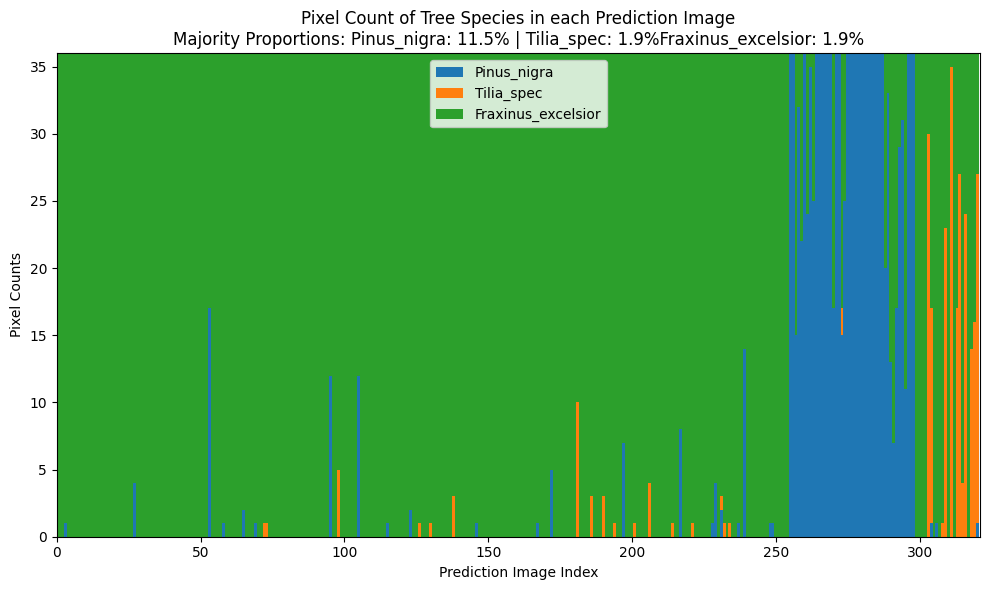

In [ ]:
# Preparing the data for the stacked histogram
counts_matrix = list(zip(*pixel_counts.values()))

# Creating the stacked histogram
plt.figure(figsize=(10, 6))
bar_width = 1  # No gap between bars

# Plotting bars for each class
bottom_heights = [0] * len(pixel_counts)
for class_idx in range(num_classes):
    plt.bar(
        range(len(pixel_counts)),
        counts_matrix[class_idx],
        width=bar_width,
        bottom=bottom_heights,
        label=SPECIES[class_idx]
    )
    bottom_heights = [sum(x) for x in zip(bottom_heights,
                                          counts_matrix[class_idx])]

# Adding the counts to the x-label
plt.ylabel('Pixel Counts')
plt.xlabel(f'Prediction Image Index')
plt.title(
    f'Pixel Count of Tree Species in each Prediction Image\n'
    f'Majority Proportions: {SPECIES[0]}: '
    f'{round(maj_sp0 / (maj_sp0 + maj_sp1 + maj_sp2) * 100, 1)}% | '
    f'{SPECIES[1]}: '
    f'{round(maj_sp1 / (maj_sp0 + maj_sp1 + maj_sp2) * 100, 1)}%'
    f'{SPECIES[2]}: '
    f'{round(maj_sp1 / (maj_sp0 + maj_sp1 + maj_sp2) * 100, 1)}%'
)
plt.xlim([0, len(pixel_counts)])  # Set x-axis limits
plt.legend()
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
# Visualize Predictions on Map - Switch to Colab
## Run the rest of the code starting here on google Colab.

 Visualization was not working in docker so we switched platforms.
 Prediction files are shared at this [link](https://drive.google.com/drive/folders/19nVhkvosBVsOAF3o8Q2r5dvmJa7DdKxZ?usp=drive_link).

# Imports and installs to run the section seperately on Colab.

In [1]:
%%capture
%pip install localtileserver
%pip install leafmap

In [2]:
import os
import rasterio
from rasterio.warp import transform_bounds
import leafmap.leafmap as leafmap
import localtileserver
import random
import pyproj
import folium
import numpy as np
from matplotlib.colors import ListedColormap

In [3]:
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

Mounted at /content/gdrive


## Import data

In [4]:
# Actual test file for the mixed classes
test_dir = f"{root}/MyDrive/EarthObservations/Presto_Project/data/Test_files"

# Path to folder
predictions_dir = f"{root}/MyDrive/EarthObservations/Presto_Project/data/predictions3"
species0_dir = f"{predictions_dir}/mode_species0"
species1_dir = f"{predictions_dir}/mode_species1"
species2_dir = f"{predictions_dir}/mode_species2"

# # File paths
prediction304_cog = f"{predictions_dir}/" \
     "Tilia_spec._2_98255_WEFL_NLF_predicted_304_cog.tif"
#actual image
test304 = f"{test_dir}/" \
     "Tilia_spec._2_98255_WEFL_NLF.tif"

# list of species
SPECIES = ["Pinus_nigra", "Tilia_spec", "Fraxinus_excelsior"]

## Visualize prediction raster examples in leafmap
#### White pixels are species 0 (Pinus_nigra), black pixels are species 1 (Tilia_spec) and blue pixels are species 2 (Fraxinus_excelsior).

The prediction rasters are saved in a public [gdrive folder](https://drive.google.com/drive/folders/19nVhkvosBVsOAF3o8Q2r5dvmJa7DdKxZ?usp=drive_link).

Here is an example of chip was predicted as Fraxinus_excelsior, the mode of the classes.
Tilia_spec._2_98255_WEFL_NLF_predicted_304_cog.tif:

<table>
  <tr>
    <td>[1</td> <td>0</td> <td>2</td> <td>1</td> <td>2</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>2</td> <td>2</td> <td>2</td> <td>1</td> <td>2]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>2</td> <td>2</td> <td>2]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>2</td> <td>2</td> <td>2]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>2</td> <td>2</td> <td>2</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>2</td> <td>1</td> <td>2</td> <td>2</td> <td>2]</td>
  </tr>
</table>



# Map the distribution of all tree species majority images.
This shows the spatial distribution the three species Germany.

Southern Germany has predominantly fraxinus_excelsiors species.

In [5]:

# Function to get the center (lat, lon) of a raster in EPSG:4326
def get_raster_center(raster_path):
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        lon = (bounds.left + bounds.right) / 2
        lat = (bounds.bottom + bounds.top) / 2
        # Perform coordinate transformation to EPSG:4326
        transformer = pyproj.Transformer.from_crs(src.crs, 'EPSG:4326',
                                                  always_xy=True)
        lon, lat = transformer.transform(lon, lat)
        lat = lat
    return lat, lon

# Create a Leafmap map centered at an initial location
m = leafmap.Map(center=[52.4, 9.5], zoom=7)

# List and process the TIFF files in species0_dir
species0_files = [f for f in os.listdir(species0_dir) if f.endswith('.tif')]
#species0_files_count = len(species0_files)
#print(species0_files_count)
for filename in species0_files:
    filepath = os.path.join(species0_dir, filename)
    lat, lon = get_raster_center(filepath)
    # White markers for species 0
    m.add_markers([lat, lon], shape='circle', color='#FFFFFF')


# List and process the TIFF files in species1_dir
species1_files = [f for f in os.listdir(species1_dir) if f.endswith('.tif')]
for filename in species1_files:
    filepath = os.path.join(species1_dir, filename)
    lat, lon = get_raster_center(filepath)
    # Red markers for species 1
    m.add_markers([lat, lon], shape='circle', color='#ff0000')

# List and process the TIFF files in species1_dir
species2_files = [f for f in os.listdir(species2_dir) if f.endswith('.tif')]
for filename in species2_files:
    filepath = os.path.join(species2_dir, filename)
    lat, lon = get_raster_center(filepath)
    # Blue markers for species 2
    m.add_markers([lat, lon], shape='circle', color='#00bfff')


labels = ['Pinus_nigra', 'Tilia_spec', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000', '00bfff']

m.add_legend(title='Legend', labels=labels,
             colors=colors)

# Add basemap
m.add_basemap("SATELLITE")

# Display the map
m

The legend colors must be a list of tuples.


Map(center=[52.4, 9.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

# Display a single raster with mixed tree values.

In [6]:
# Create a Leafmap map centered at an initial location
# Use the center of the first raster as initial location
initial_location = get_raster_center(prediction304_cog)

m = leafmap.Map(center=initial_location, zoom=18)

# Add basemap
m.add_basemap("SATELLITE")

# Define a binary palette (0: white, 1: red) using hex codes
binary_palette = ['#FFFFFF', '#ff0000', '#00bfff']
marker_color = '#00bfff' #blue

lat, lon = initial_location

m.add_markers([lat, lon], shape='circle', color=marker_color)

# actual test file
m.add_raster(test304, band=2, palette=binary_palette, layer_name='Test Image 304')

# predicted image
m.add_raster(prediction304_cog, band=13, palette=binary_palette, layer_name='Predicted Image 304')

labels = ['Pinus_nigra', 'Tilia_spec', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000', '#00bfff']
m.add_legend(title='Legend', labels=labels,
             colors=colors)



# Display the map
m

INFO:large_image:Cannot use memcached for caching.


Map(center=[52.404896892705054, 9.906381770775875], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Randomly select 10 rasters of each species majority

In [7]:

# Set a seed for reproducibility
random.seed(42)

# List files in each directory
species0_files = [os.path.join(species0_dir, f) for f in os.listdir(species0_dir) if f.endswith('.tif')]
species1_files = [os.path.join(species1_dir, f) for f in os.listdir(species1_dir) if f.endswith('.tif')]
species2_files = [os.path.join(species2_dir, f) for f in os.listdir(species2_dir) if f.endswith('.tif')]

# Randomly select up to 10 rasters from each category
selected_species0 = random.sample(species0_files, min(len(species0_files), 5))
selected_species1 = random.sample(species1_files, min(len(species1_files), 5))
selected_species2 = random.sample(species2_files, min(len(species2_files), 5))

# Print selected file names
print(f'Selected {SPECIES[0]} (species0) images:')
for filepath in selected_species0:
    print(os.path.basename(filepath))


print(f'Selected {SPECIES[1]} (species1) images:')
for filepath in selected_species1:
    print(os.path.basename(filepath))

print(f'Selected {SPECIES[2]} (species2) images:')
for filepath in selected_species2:
    print(os.path.basename(filepath))


Selected Pinus_nigra (species0) images:
Pinus_nigra_2_50999_WEFL_NLF_predicted_258_cog.tif
Pinus_nigra_2_51744_WEFL_NLF_predicted_260_cog.tif
Pinus_nigra_4_53059_WEFL_NLF_predicted_274_cog.tif
Pinus_nigra_2_52488_WEFL_NLF_predicted_263_cog.tif
Pinus_nigra_2_52218_WEFL_NLF_predicted_261_cog.tif
Selected Tilia_spec (species1) images:
Tilia_spec._4_96172_WEFL_NLF_predicted_314_cog.tif
Tilia_spec._2_96553_WEFL_NLF_predicted_303_cog.tif
Tilia_spec._7_98414_WEFL_NLF_predicted_320_cog.tif
Tilia_spec._3_98257_WEFL_NLF_predicted_311_cog.tif
Tilia_spec._4_97761_WEFL_NLF_predicted_316_cog.tif
Selected Fraxinus_excelsior (species2) images:
Fraxinus_excelsior_1_32218_WEFL_NLF_predicted_8_cog.tif
Fraxinus_excelsior_1_31955_WEFL_NLF_predicted_6_cog.tif
Fraxinus_excelsior_2_32191_WEFL_NLF_predicted_45_cog.tif
Fraxinus_excelsior_3_31796_WEFL_NLF_predicted_98_cog.tif
Fraxinus_excelsior_4_30563_WEFL_NLF_predicted_131_cog.tif


## Display 10 of each majority prediction tiles.

In [8]:
# Create a Leafmap map centered at an initial location
# Use the center of the first raster as initial location
initial_location = get_raster_center(selected_species0[0])
m = leafmap.Map(center=initial_location, zoom=18)

# Add basemap
m.add_basemap("SATELLITE")

# Define a binary palette (0: white, 1: red) using hex codes
binary_palette = ['#FFFFFF', '#ff0000', '#00bfff']
#Problem displaying secies1 as red, forcing red for now
binary_palette2 = ['#ff0000', '#ff0000']

# Add selected rasters and markers
for cog in selected_species0:
    lat, lon = get_raster_center(cog)
    marker_color = '#FFFFFF' #white
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette)

for cog in selected_species1:
    lat, lon = get_raster_center(cog)
    marker_color = '#ff0000' #red
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette)

for cog in selected_species2:
    lat, lon = get_raster_center(cog)
    marker_color = '#00bfff' #blue
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette)


labels = ['Pinus_nigra', 'Tilia_spec', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000', '#00bfff']
m.add_legend(title='Legend', labels=labels,
             colors=colors)
# Display the map
m


Map(center=[52.92769970374674, 8.169506647473273], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Display rasters for all the three species with mixed tree values.
We display images that were classifed as 0 - Pinu_nigra but had mixed classification of 0 and 2

of the 36 images. These imaged are saved in [here](https://drive.google.com/drive/folders/1HTw2GRizvVl_BHSEMO8tI9HOUKfKmpqp?usp=drive_link)

Images that were prediction mode of 1 - Tilia_spec but had mixed classification of 0 and 1 [here](https://drive.google.com/drive/folders/1Z1j-L3aRiYpUoq2jG25Zx17jkkqo6S2t?usp=drive_link)

Images that were prediction mode of 2 (Fraxinus_excelsior) have mixed classification of 2 and 0 [here](https://drive.google.com/drive/folders/152tRPSeJYNTu43sAE20VMVDuJWWU87wT?usp=drive_link)

 Images that were prediction mode of 2 have mixed classification of 2, 1 and 0  [here](https://drive.google.com/drive/folders/1MWZ2Ou1XPD8huS3CDGHC2VscFPtefjzR?usp=drive_link)

In [9]:
# list of actual mixed species
testfiles_0 = [
    f"{test_dir}/Pinus_nigra_2_50999_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_2_51340_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_2_52218_WEFL_NLF.tif"]

testfiles_1 = [f"{test_dir}/Tilia_spec._2_96553_WEFL_NLF.tif"]

testfiles_2 = [
    f"{test_dir}/Fraxinus_excelsior_2_30742_WEFL_NLF.tif",
    f"{test_dir}/Fraxinus_excelsior_4_31272_WEFL_NLF.tif",
    f"{test_dir}/Fraxinus_excelsior_2_329912_BI_NLF.tif",
    ]

testfiles_2all = [
    f"{test_dir}/Fraxinus_excelsior_9_30246_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_4_51863_WEFL_NLF.tif",
    f"{test_dir}/Tilia_spec._2_98255_WEFL_NLF.tif"]


# List of Species classified as 0 with (0,2) mixed classes
prediction_0_mixed = [
    f"{species0_dir}/Pinus_nigra_2_50999_WEFL_NLF_predicted_258_cog.tif",
    f"{species0_dir}/Pinus_nigra_2_51340_WEFL_NLF_predicted_259_cog.tif",
    f"{species0_dir}/Pinus_nigra_2_52218_WEFL_NLF_predicted_261_cog.tif"]

# List of Species classified as 1 with (0,1) mixed classes
prediction_1_mixed = [
    f"{species1_dir}/Tilia_spec._2_96553_WEFL_NLF_predicted_303_cog.tif"]

# List of Species classified as 2 with (2,0 or 2,1) all three mixed species
prediction_2_mixed = [
    f"{species2_dir}/Fraxinus_excelsior_2_30742_WEFL_NLF_predicted_27_cog.tif",
    f"{species2_dir}/Fraxinus_excelsior_4_31272_WEFL_NLF_predicted_138_cog.tif",
    f"{species2_dir}/Fraxinus_excelsior_2_329912_BI_NLF_predicted_53_cog.tif"]

    # List of Species classified as 2 with all three mixed species
prediction_2all_mixed = [
    f"{species2_dir}/Fraxinus_excelsior_9_30246_WEFL_NLF_predicted_231_cog.tif",
    f"{species2_dir}/Pinus_nigra_4_51863_WEFL_NLF_predicted_273_cog.tif",
    f"{species2_dir}/Tilia_spec._2_98255_WEFL_NLF_predicted_304_cog.tif"]



In [10]:
m = leafmap.Map(center=initial_location, zoom=18)

# Add basemap
m.add_basemap("SATELLITE")

# Define a binary palette (0: white, 1: red) using hex codes
binary_palette = ['#FFFFFF', '#ff0000', '#00bfff']

# Add selected Actual images
for tiff in testfiles_0:
        # actual test file
    m.add_raster(tiff, band=2, palette=binary_palette,
                 layer_name='Test 1')

for tiff2 in testfiles_1:
        # actual test file
    m.add_raster(tiff2, band=2, palette=binary_palette,
                 layer_name='Test 2')

for tiff in testfiles_2:
        # actual test file
    m.add_raster(tiff, band=2, palette=binary_palette,
                 layer_name='Test 3')

for tiff in testfiles_2all:
        # actual test file
    m.add_raster(tiff, band=2, palette=binary_palette,
                 layer_name='Test 4')

# Add selected predicted rasters and markers

for cog in prediction_0_mixed:
    lat, lon = get_raster_center(cog)
    marker_color = '#FFFFFF' #white
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette,
                 layer_name='Predicted (0) with mixed piexls(2,0)')

for cog in prediction_1_mixed:
    lat, lon = get_raster_center(cog)
    marker_color = '#ff0000' #red
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette,
                 layer_name='Predicted (1) with mixed piexls(1,0)')

for cog in prediction_2_mixed:
    lat, lon = get_raster_center(cog)
    marker_color = '#00bfff' #blue
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette,
                 layer_name='Predicted(2) with mixed piexls(2,0)')

for cog in prediction_2all_mixed:
    lat, lon = get_raster_center(cog)
    marker_color = '#00bfff' #blue
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette,
                 layer_name='Predicted (2) with All of 3 species')


labels = ['Pinus_nigra', 'Tilia_spec', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000', '#00bfff']
m.add_legend(title='Legend', labels=labels,
             colors=colors)
# Display the map
m

Map(center=[52.92769970374674, 8.169506647473273], controls=(ZoomControl(options=['position', 'zoom_in_text', …